In [710]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [711]:
df=pd.read_csv('audi.csv',skipinitialspace=True)

In [712]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


I will reorder the columns to group the categorical variables first and then the numerical ones

In [713]:
df=df[['model','year','transmission','fuelType','mileage','tax','mpg','engineSize','price']]

In [714]:
df.head()

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
0,A1,2017,Manual,Petrol,15735,150,55.4,1.4,12500
1,A6,2016,Automatic,Diesel,36203,20,64.2,2.0,16500
2,A1,2016,Manual,Petrol,29946,30,55.4,1.4,11000
3,A4,2017,Automatic,Diesel,25952,145,67.3,2.0,16800
4,A3,2019,Manual,Petrol,1998,145,49.6,1.0,17300


In [715]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   transmission  10668 non-null  object 
 3   fuelType      10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   tax           10668 non-null  int64  
 6   mpg           10668 non-null  float64
 7   engineSize    10668 non-null  float64
 8   price         10668 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB


There are no missing values

In [716]:
#Convert year column to object so we can include it in the categorical mask
df['year']=df['year'].astype(object)

In [717]:
# Create a boolean mask for categorical columns
categorical_mask = (df.dtypes == object)

In [718]:
categorical_columns = df.columns[categorical_mask].tolist()

In [719]:
print(df[categorical_columns].head())

  model  year transmission fuelType
0    A1  2017       Manual   Petrol
1    A6  2016    Automatic   Diesel
2    A1  2016       Manual   Petrol
3    A4  2017    Automatic   Diesel
4    A3  2019       Manual   Petrol


In [720]:
df[categorical_columns].describe()

,model,year,transmission,fuelType
count,10668,10668,10668,10668
unique,26,21,3,3
top,A3,2019,Manual,Diesel
freq,1929,3197,4369,5577


In [721]:
#COLUMN TRANSFORMER to get OH conded cols!
#This allows us to skip the label encoder and directly apply the one hot encoding!


#from sklearn.preprocessing import OneHotEncoder
#from sklearn.compose import ColumnTransformer
#ct = ColumnTransformer([(categorical_columns, OneHotEncoder(), [0])], remainder = 'passthrough')
#df[categorical_columns] = ct.fit_transform(df[categorical_columns])

In [722]:
#Use get dummies instead of one hot encoding, 

#Create a copy of the DF where we substitue the categorical column into more cols with dummies
encoded_df=df.copy()
encoded_df = pd.concat([df.drop(categorical_columns, axis=1), pd.get_dummies(df[categorical_columns], drop_first=True)], axis=1)

## One Hot encoding

In [723]:
enc = OneHotEncoder(handle_unknown='error')
enc.fit(df[categorical_columns])

OneHotEncoder()

In [724]:
df[categorical_columns]

,model,year,transmission,fuelType
0,A1,2017,Manual,Petrol
1,A6,2016,Automatic,Diesel
2,A1,2016,Manual,Petrol
3,A4,2017,Automatic,Diesel
4,A3,2019,Manual,Petrol
...,...,...,...,...
10663,A3,2020,Manual,Petrol
10664,A3,2020,Manual,Petrol
10665,A3,2020,Manual,Petrol
10666,Q3,2017,Automatic,Petrol


In [725]:
import joblib
joblib.dump(enc, 'encoder.joblib')

['encoder.joblib']

In [726]:
df_encode = df[categorical_columns]
df_encode = pd.DataFrame(data=enc.transform(df_encode).toarray(),columns=enc.get_feature_names(categorical_columns), dtype=bool)
# trasfer true and false to 1 and 0
df_encode = df_encode * 1

# concatenate data
df_OHE = pd.concat((df.drop(categorical_columns, axis=1), df_encode), axis=1)
df_OHE.head()

,mileage,tax,mpg,engineSize,price,model_A1,model_A2,model_A3,model_A4,model_A5,...,year_2017,year_2018,year_2019,year_2020,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol
0,15735,150,55.4,1.4,12500,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
1,36203,20,64.2,2.0,16500,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,29946,30,55.4,1.4,11000,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,25952,145,67.3,2.0,16800,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
4,1998,145,49.6,1.0,17300,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1


In [727]:
encoded_df=df_OHE
encoded_df.head()

,mileage,tax,mpg,engineSize,price,model_A1,model_A2,model_A3,model_A4,model_A5,...,year_2017,year_2018,year_2019,year_2020,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol
0,15735,150,55.4,1.4,12500,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
1,36203,20,64.2,2.0,16500,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,29946,30,55.4,1.4,11000,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,25952,145,67.3,2.0,16800,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
4,1998,145,49.6,1.0,17300,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1


I have 58 columns: 5 (numeric_cols) + 53 (unique cateogric_cols) = 58

Now the data is ready for the learning

### Prepare the data for learning

In [728]:
X=encoded_df.drop('price', axis = 1).values

In [729]:
y=encoded_df['price'].values

In [730]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 69)

In [731]:
scaler = StandardScaler()

In [732]:
scaler.fit(X_train)

StandardScaler()

In [733]:
X_train = scaler.transform(X_train)          # Apply Standardization on X_train
X_test = scaler.transform(X_test)            # Apply Standardization on X_test

## Support Vector Regression

In [56]:
from sklearn.svm import SVR

In [57]:
param_SVM = {'C':np.arange(100,5000,50),
            'gamma':np.arange(0.01, 0.9, 0.01)}

In [59]:
svr_model=SVR()

In [60]:
cv_SVM = RandomizedSearchCV(estimator=svr_model, param_distributions = param_SVM, n_iter=10, cv = 5)

In [61]:
cv_SVM.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions={'C': array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100, 1150,
       1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700,
       1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250,
       2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800,
       2850, 2900, 2950, 3000, 3...
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
 

In [62]:
y_pred_SVM = cv_SVM.predict(X_test)

In [63]:
# Compute and print the metrics
print("Tuned SVM parameters: {}".format(cv_SVM.best_params_))

Tuned SVM parameters: {'gamma': 0.03, 'C': 3850}


## XGBoost

In [315]:
import xgboost as xgb

In [30]:
# Create the parameter grid
param_grid = {
    'learning_rate': np.arange(0.01, 0.5, 0.01),
    'max_depth': np.arange(3, 30, 2),
    'n_estimators': np.arange(50, 200, 15)
}

In [31]:
xgb_model=xgb.XGBRegressor()

In [32]:
rand_neg_mse = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=10, scoring='neg_mean_squared_error', cv=3)

In [33]:
rand_neg_mse.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print("Best rmse:", np.sqrt(np.abs(rand_neg_mse.best_score_)))

In [ ]:
print("Best model: ", rand_neg_mse.best_estimator_)

In [ ]:
y_pred_RND = rand_neg_mse.predict(X_test)

In [ ]:
# Compute and print the metrics
print("Tuned XGB parameters by RandomizedGridSearch: {}".format(rand_neg_mse.best_params_))

## XGBoost with Hyperopt by Baesian method

In [672]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [697]:
space={'max_depth': hp.choice("max_depth", np.arange(3, 18, 1)),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'learning_rate': hp.quniform("learning_rate", 0.0001, 0.5, 0.01),
      }

In [698]:
def hyperparameter_tuning(space):
    print(space)
    model = xgb.XGBRegressor(max_depth =space['max_depth'],
                           min_child_weight=space['min_child_weight'],
                           gamma = space['gamma'],
                           reg_alpha = space['reg_alpha'],
                           reg_lambda = space['reg_lambda'],
                            learning_rate=space['learning_rate'])

    eval_set  = [( X_train, y_train), ( X_test, y_test)]

    model.fit(X_train, y_train,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(X_test)
    mse_scr = mean_squared_error(y_test, pred)
    print("SCORE:", np.sqrt(mse_scr))
    #change the metric if you like
    return {'loss':mse_scr, 'status': STATUS_OK }

In [699]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print (best)

{'gamma': 5.496770067050895, 'learning_rate': 0.43, 'max_depth': 10, 'min_child_weight': 2.0, 'reg_alpha': 72.0, 'reg_lambda': 0.22065046099046792}
SCORE:                                                                                                                 
2493.3234746648727                                                                                                     
{'gamma': 5.538990051615587, 'learning_rate': 0.27, 'max_depth': 10, 'min_child_weight': 0.0, 'reg_alpha': 169.0, 'reg_lambda': 0.8752148737081793}
SCORE:                                                                                                                 
2420.5552896656                                                                                                        
{'gamma': 8.280063149879656, 'learning_rate': 0.35000000000000003, 'max_depth': 9, 'min_child_weight': 10.0, 'reg_alpha': 112.0, 'reg_lambda': 0.21135537728397824}
SCORE:                                                      

{'gamma': 7.290944776166098, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 4.0, 'reg_alpha': 42.0, 'reg_lambda': 0.010763976124866514}
SCORE:                                                                                                                 
10574.54565555148                                                                                                      
{'gamma': 6.669826140788469, 'learning_rate': 0.5, 'max_depth': 12, 'min_child_weight': 5.0, 'reg_alpha': 116.0, 'reg_lambda': 0.5798067073502158}
SCORE:                                                                                                                 
2481.93168195063                                                                                                       
{'gamma': 2.7542239547984138, 'learning_rate': 0.17, 'max_depth': 4, 'min_child_weight': 5.0, 'reg_alpha': 176.0, 'reg_lambda': 0.3194587044628552}
SCORE:                                                                       

{'gamma': 4.914970764787175, 'learning_rate': 0.22, 'max_depth': 17, 'min_child_weight': 7.0, 'reg_alpha': 178.0, 'reg_lambda': 0.5269493430326597}
SCORE:                                                                                                                 
2429.8314859345064                                                                                                     
{'gamma': 5.68336222466799, 'learning_rate': 0.17, 'max_depth': 7, 'min_child_weight': 8.0, 'reg_alpha': 94.0, 'reg_lambda': 0.20834004073421142}
SCORE:                                                                                                                 
2349.755555706038                                                                                                      
{'gamma': 3.3518868351761384, 'learning_rate': 0.27, 'max_depth': 13, 'min_child_weight': 9.0, 'reg_alpha': 139.0, 'reg_lambda': 0.7321070242430967}
SCORE:                                                                       

In [734]:
print("The best hyperparameters are : ","\n")
print(best)

The best hyperparameters are :  

{'gamma': 6.3024069373388585, 'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 6.0, 'reg_alpha': 97.0, 'reg_lambda': 0.3261508451811253}


In [735]:
xgb_opt = xgb.XGBRegressor(max_depth = best['max_depth'],
                       gamma = best['gamma'],
                       reg_lambda = best['reg_lambda'],
                       reg_alpha = best['reg_alpha'],
                       min_child_weight = best['min_child_weight'],
                          learning_rate=best['learning_rate'],)

In [736]:
xgb_opt.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=6.3024069373388585,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=13,
             min_child_weight=6.0, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=97.0, reg_lambda=0.3261508451811253, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [737]:
# Predicting the Test set results
y_pred_XGB_OPT = xgb_opt.predict(X_test)

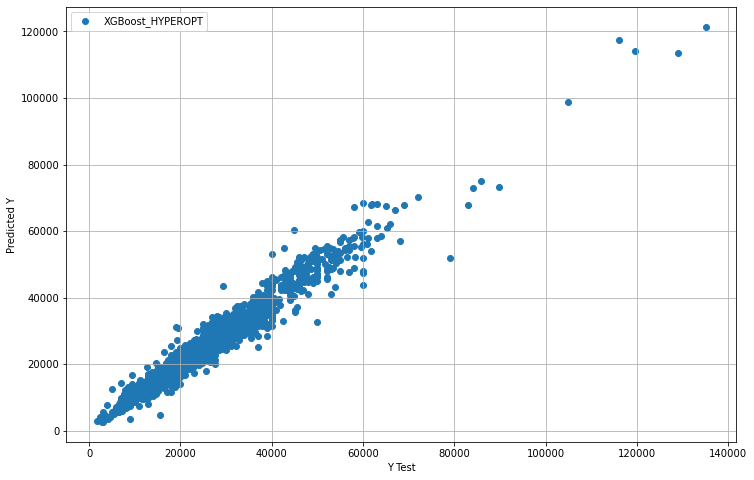

In [738]:
plt.figure(figsize = (12,8))

#plt.scatter(y_test, y_pred_SVM, label='SVM')
#plt.scatter(y_test, y_pred_RND, label='XGBoost')
plt.scatter(y_test, y_pred_XGB_OPT, label='XGBoost_HYPEROPT')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.legend(loc='upper left');
plt.grid()

In [739]:
#mse_SVM = mean_squared_error(y_test, y_pred_SVM)
mse_XGB_OPT = mean_squared_error(y_test, y_pred_XGB_OPT)
#print("RMSE using SVM: ", np.sqrt(mse_SVM))
#print("RMSE using XGBoost: ", np.sqrt(np.abs(rand_neg_mse.best_score_)))
print("RMSE using XGBoost_HYPEROPT: ", np.sqrt(mse_XGB_OPT))

RMSE using XGBoost_HYPEROPT:  2329.9167147431763


We get better results with XGBoost and we can even improve the RMSE with the Baesian optimization

In [740]:
import pickle

In [741]:
pickle.dump(xgb_opt, open('model.pkl','wb'))

In [742]:
pickle.dump(scaler, open('scaler.pkl','wb'))

# DEBUG FOR ML DEPLYMENT

In [743]:
df.head()

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
0,A1,2017,Manual,Petrol,15735,150,55.4,1.4,12500
1,A6,2016,Automatic,Diesel,36203,20,64.2,2.0,16500
2,A1,2016,Manual,Petrol,29946,30,55.4,1.4,11000
3,A4,2017,Automatic,Diesel,25952,145,67.3,2.0,16800
4,A3,2019,Manual,Petrol,1998,145,49.6,1.0,17300


In [744]:
feat=['A1','2017','Manual','Petrol','15735','150']

In [746]:
num_feat = np.append(feat[4:6],[55.4,1.4])
num_feat

array(['15735', '150', '55.4', '1.4'], dtype='<U32')

In [747]:
df_cat=pd.DataFrame([feat[0:4]], columns=['model','year','transmission','fuelType'])
df_cat

,model,year,transmission,fuelType
0,A1,2017,Manual,Petrol


In [748]:
df_cat.year=int(df_cat.year)

In [749]:
cat_feat = enc.transform(df_cat).toarray()

In [750]:
enc_feat = np.append(num_feat, cat_feat)

In [751]:
 scaled_feat=scaler.transform(enc_feat.reshape(1,-1))

In [754]:
prediction = xgb_opt.predict(scaled_feat)[0]
prediction

13940.737